
--- Benchmarking Generation of 2000 bits ---
Method               | Time (sec) | Speed (bits/s) 
--------------------------------------------------
Local Qiskit Sim     | 0.00897 s  | 222964
Classical OS         | 0.00014 s  | 14230419
Remote ANU API       | 3.02385 s  | 661


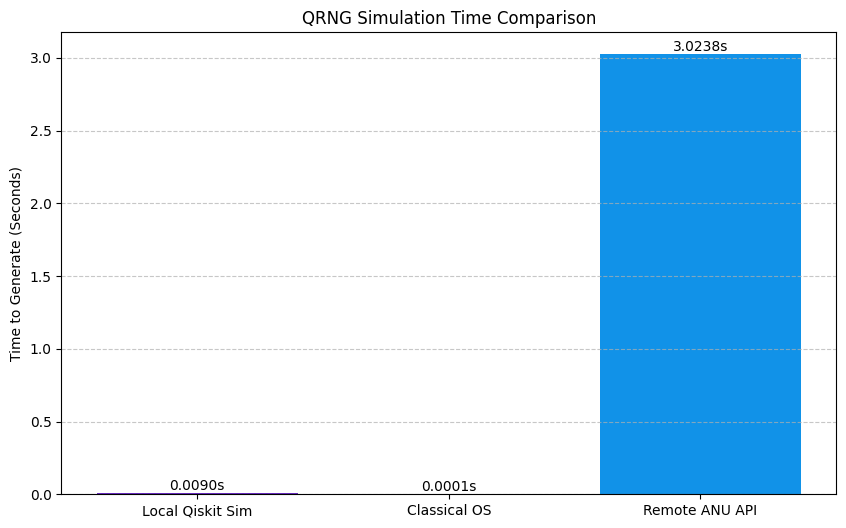

In [ ]:
!pip install qiskit qiskit-aer matplotlib

import time
import secrets
import requests
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

# --- 1. Local Quantum Simulation (Qiskit) ---
class QuantumSimulatorRNG:
    def __init__(self):
        self.backend = AerSimulator()

    def generate_bits(self, num_bits):
        qc = QuantumCircuit(1, 1)
        qc.h(0)
        qc.measure(0, 0)
        job = self.backend.run(qc, shots=num_bits, memory=True)
        result = job.result()
        memory = result.get_memory()
        return "".join(memory)

# --- 2. Remote True Quantum (ANU API) ---
class AnuWebQRNG:
    def __init__(self):
        self.url = "https://qrng.anu.edu.au/API/jsonI.php"

    def generate_bits(self, num_bits):
        num_bytes = (num_bits // 8) + 1
        params = {
            "length": num_bytes,
            "type": "uint8"
        }

        try:
            response = requests.get(self.url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()["data"]
            binary_string = "".join(f"{x:08b}" for x in data)
            return binary_string[:num_bits]

        except Exception as e:
            return f"Error: {e}"

# --- 3. Classical Baseline (Python Secrets) ---
class ClassicalRNG:
    def generate_bits(self, num_bits):
        num_bytes = (num_bits // 8) + 1
        random_bytes = secrets.token_bytes(num_bytes)

        binary_string = "".join(f"{x:08b}" for x in random_bytes)
        return binary_string[:num_bits]

# --- 4. Benchmarking Engine ---
def run_benchmark(target_bits=1024):
    generators = {
        "Local Qiskit Sim": QuantumSimulatorRNG(),
        "Classical OS": ClassicalRNG(),
        "Remote ANU API": AnuWebQRNG()
    }

    results = {}

    print(f"\n--- Benchmarking Generation of {target_bits} bits ---")
    print(f"{'Method':<20} | {'Time (sec)':<10} | {'Speed (bits/s)':<15}")
    print("-" * 50)

    for name, gen in generators.items():
        start_time = time.perf_counter()
        bits = gen.generate_bits(target_bits)
        end_time = time.perf_counter()

        duration = end_time - start_time

        if "Error" in bits:
            print(f"{name:<20} | FAILED     | {bits}")
            continue

        speed = target_bits / duration
        results[name] = duration

        print(f"{name:<20} | {duration:.5f} s  | {speed:.0f}")

    return results

# --- 5. Visualization ---
def plot_results(results):
    names = list(results.keys())
    times = list(results.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, times, color=['#6929c4', '#009d9a', '#1192e8'])

    plt.ylabel('Time to Generate (Seconds)')
    plt.title('QRNG Simulation Time Comparison')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}s', va='bottom', ha='center')

    plt.show()

if __name__ == "__main__":
    data = run_benchmark(target_bits=2000)
    plot_results(data)
